# Install Qiskit package

# Importing Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Options

from qiskit.quantum_info import Statevector

%matplotlib inline

In [ ]:
api_token = "<YOUR API TOKEN>"

# Task 1

Model the circuit presented in Qiskit. What are the probabilities of the states?

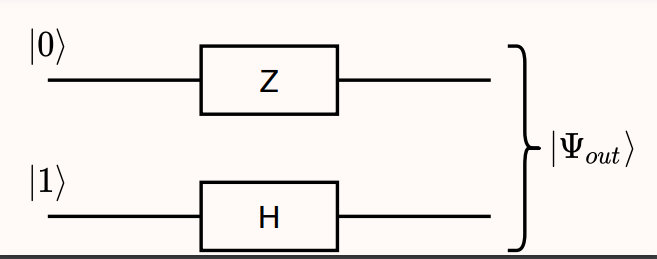

Ideal Statevector Simulation without Measurement

In [ ]:
#Create the empty quantum circuit object with 2 quantum bits and 2 classical bits to store the output
circ_ideal_task1 = QuantumCircuit(2, 2)

#Let's now add the Z and H gates to the quantum circuit
circ_ideal_task1.z(0)
circ_ideal_task1.h(1)

#Now we can draw the circuit
circ_ideal_task1.draw('mpl')

In [ ]:
# Let's now simulate this circuit with the ideal statevector simulator

# First we set the backend to the statevector_simulator from the Aer library imported with Qiskit
backend_ideal = Aer.get_backend('statevector_simulator')

# Next we can create a job for running the circuit we created
job_task1     = backend_ideal.run(circ_ideal_task1)

# Now we can look at the results
result_task1  = job_task1.result()
output_task1  = result_task1.get_statevector(circ_ideal_task1)
print("Statevector: " + str(output_task1))

Ideal Statistical Simulation with Measurement

In [ ]:
# We can also use the OpenQASM backend to build up measurement statistics by adding measurements
circ_meas_task1 = QuantumCircuit(2, 2)

#Let's now add the Z and H gates to the quantum circuit
circ_meas_task1.z(0)
circ_meas_task1.h(1)

#Add in measurement
circ_meas_task1.measure([0,1], [0,1])

#Now we can draw the circuit
circ_meas_task1.draw('mpl')

In [ ]:
# LOCAL SIMULATOR

# Use Aer's qasm_simulator when using measurement
backend_qasm = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit to be 1024, which is the default.
num_shots    = 1024
job_qasm     = backend_qasm.run(transpile(circ_meas_task1, backend_qasm), shots=num_shots)

# Grab the results from the job.
result_sim   = job_qasm.result()
counts       = result_sim.get_counts(circ_meas_task1)
for key in counts.keys():
  print("P(" + str(key) + ") = " + str(counts[key]/num_shots))

plot_histogram(counts)

Run using QiskitRuntimeService using Samplers on a Quantum Computer

In [ ]:
# CLOUD SIMULATION with real backend
# Run using the QiskitRuntimeService

# Save an IBM Quantum account.
service = QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum")

# List all available backends
service.backends()

# Filter available backends
available_backends = service.backends(simulator=False, operational=True, min_num_qubits=5)
print(available_backends)

# Choose a backend and extract information about it
backend = service.backend("ibmq_qasm_simulator") #CHANGE TO ONE OF AVAILABLE QUANTUM COMPUTERS
print("Backend Name: " + str(backend.name)) #returns the backend's name
print("Backend Version: " + str(backend.backend_version)) #returns the version number
print("Backend Simulator: " +  str(backend.simulator)) #returns True or False, depending on whether it is a simulator
print("Backend Num Qubits: " + str(backend.num_qubits)) #returns the number of qubits the backend has

# Run a job
num_shots = 1024
sampler = Sampler(backend=backend)
job = sampler.run(circuits=circ_meas_task1, shots=num_shots)

# Extract results from job
result_sim = job.result()
prob_outputs = result_sim.quasi_dists[0].binary_probabilities()

for key in prob_outputs:
  print("P(" + str(key) + ") = " + str(prob_outputs[key]))

counts = {key: value*num_shots for key,value in prob_outputs.items()}

plot_histogram(prob_outputs)

It can take a long time to get access to an actual quantum computer on the network. So instead we can create our own backend and import the noise profile of one of the actual computers and simulate locally.

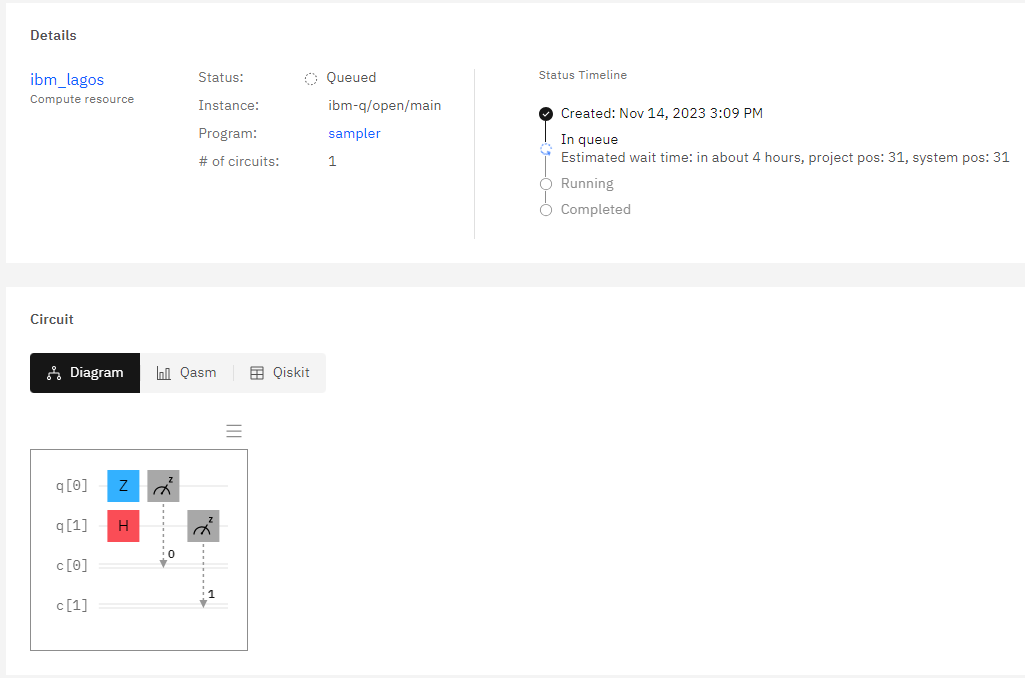

In [ ]:
# LOCAL SIMULATION with noisy fake backend (AER)
from qiskit_ibm_provider import IBMProvider
from qiskit_aer.backends.aer_simulator import AerSimulator
from qiskit_aer.noise import NoiseModel

# We can create a backend using real noise attributes of an actual device
provider = IBMProvider(token=api_token)

# Get a real backend from a real provider
real_backend = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(real_backend)

# Get coupling map from backend
coupling_map = real_backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
backend_sim = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

# Run a job
num_shots = 1024
transpiled_circuit = transpile(circ_meas_task1, backend_sim)
job = backend_sim.run(circuits=transpiled_circuit, shots=num_shots)

# Extract results from job
result_sim = job.result()
count_outputs = result_sim.get_counts()

for key in count_outputs:
  print("P(" + str(key) + ") = " + str(count_outputs[key]/num_shots))

plot_histogram(count_outputs)

In [ ]:
# CLOUD SIMULATION with noisy fake backend
# Run using the QiskitRuntimeService

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=api_token, overwrite=True)
service = QiskitRuntimeService()

# List all available backends
all_backends = service.backends()
print(all_backends)

# Filter available backends
available_backends = service.backends(simulator=False, operational=True, min_num_qubits=5)
print(available_backends)

# Choose a backend and extract information about it
backend = service.backend('ibmq_qasm_simulator')
print("Backend Name: " + str(backend.name)) #returns the backend's name
print("Backend Version: " + str(backend.backend_version)) #returns the version number
print("Backend Simulator: " +  str(backend.simulator)) #returns True or False, depending on whether it is a simulator
print("Backend Num Qubits: " + str(backend.num_qubits)) #returns the number of qubits the backend has

# Make a noise model
# Get a real backend from a real provider
real_backend = service.backend('ibm_lagos')
noise_model  = NoiseModel.from_backend(real_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": real_backend.configuration().basis_gates,
    "coupling_map": real_backend.configuration().coupling_map,
    "seed_simulator": 42
}
# Set number of shots, optimization_level and resilience_level
options.optimization_level = 0
options.resilience_level = 0

# Run a job
sampler = Sampler(backend=backend, options=options)
job = sampler.run(circuits=circ_meas_task1, shots=num_shots)

# Extract results from job
result_sim = job.result()
prob_outputs = result_sim.quasi_dists[0].binary_probabilities()

for key in prob_outputs:
  print("P(" + str(key) + ") = " + str(prob_outputs[key]))

counts = {key: value*num_shots for key,value in prob_outputs.items()}

plot_histogram(prob_outputs)

# Task 2

Model the circuit in Qiskit. What are the probabilities of the states?

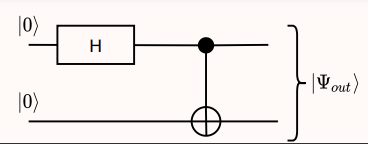

Ideal Statevector Simulation without Measurement

In [ ]:
#Create the empty quantum circuit object with 2 quantum bits and 2 classical bits to store the output
circ_ideal_task2 = QuantumCircuit(2, 2)

#Let's now add the H and CNOT gates to the quantum circuit
circ_ideal_task2.h(0)
circ_ideal_task2.cnot(0,1)

#Now we can draw the circuit
circ_ideal_task2.draw('mpl')

In [ ]:
# Let's now simulate this circuit with the ideal statevector simulator

# First we set the backend to the statevector_simulator from the Aer library imported with Qiskit
backend_ideal = Aer.get_backend('statevector_simulator')

# Next we can create a job for running the circuit we created
job_task2     = backend_ideal.run(circ_ideal_task2)

# Now we can look at the results
result_task2  = job_task2.result()
output_task2  = result_task2.get_statevector(circ_ideal_task2)
print("Statevector: " + str(output_task2))

Statistical Simulation with Measurement

In [ ]:
# We can also use the OpenQASM backend to build up measurement statistics by adding measurements
circ_meas_task2 = QuantumCircuit(2, 2)

#Let's now add the H and CNOT gates to the quantum circuit
circ_meas_task2.h(0)
circ_meas_task2.cnot(0,1)

#Add in measurement
circ_meas_task2.measure([0,1], [0,1])

#Now we can draw the circuit
circ_meas_task2.draw('mpl')

In [ ]:
# Use Aer's qasm_simulator
backend_qasm = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit to be 1024, which is the default.
num_shots    = 1024
job_qasm     = backend_qasm.run(transpile(circ_meas_task2, backend_qasm), shots=num_shots)

# Grab the results from the job.
result_sim   = job_qasm.result()
counts       = result_sim.get_counts(circ_meas_task2)
for key in counts.keys():
  print("P(" + str(key) + ") = " + str(counts[key]/num_shots))

plot_histogram(counts)

Noisy Statistical Simulation with Measurement

In [ ]:
# Let's now simulate this circuit with the noisy simulator

# We can create a backend using real noise attributes of an actual device
provider = IBMProvider(token=api_token)

# Get a real backend from a real provider
real_backend  = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(real_backend)

# Get coupling map from backend
coupling_map = real_backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Perform a noise simulation
backend_sim = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

# Execute the circuit on the local Aer simulator
# We've set the number of shots of the circuit to be 1024
num_shots    = 1024
job_noisy    = backend_sim.run(transpile(circ_meas_task2, backend_sim), shots=num_shots)

# Grab the results from the job.
result_sim   = job_noisy.result()
counts       = result_sim.get_counts(circ_meas_task2)
for key in counts.keys():
  print("P(" + str(key) + ") = " + str(counts[key]/num_shots))

plot_histogram(counts)

# Task 3

Model the circuit in Qiskit. What does it do?

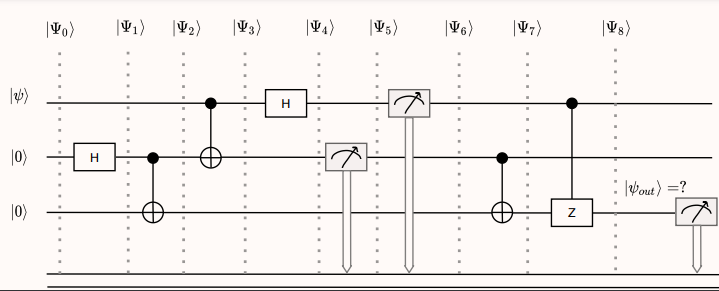

Ideal Statevector Simulation

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


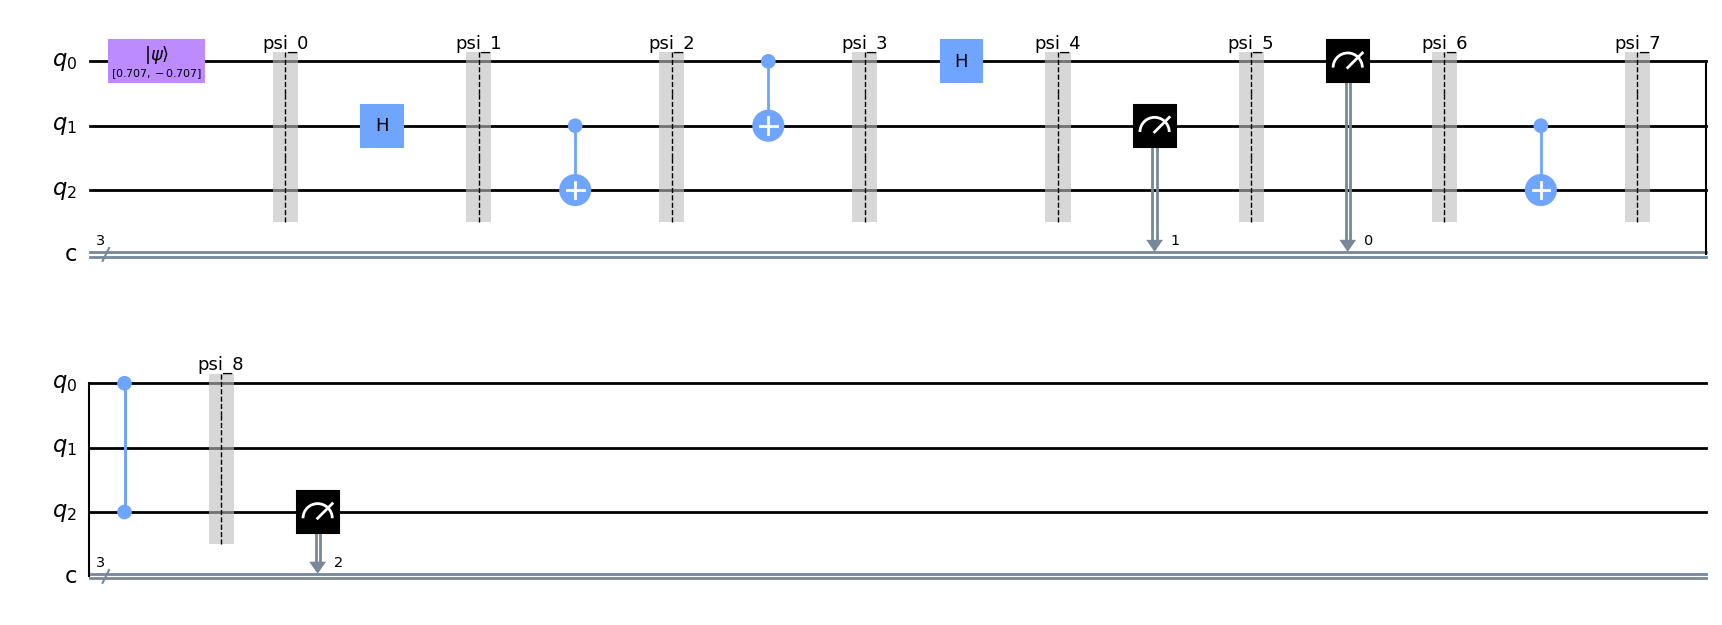

In [ ]:
#Create the empty quantum circuit object with 3 quantum bits and 3 classical bits to store the output
circ_ideal_task3 = QuantumCircuit(3, 3)

#Initialise first qubit
circ_ideal_task3.initialize([1/np.sqrt(2), -1/np.sqrt(2)], 0)

#Let's now add the H and CNOT gates to the quantum circuit
circ_ideal_task3.save_statevector(label='psi_0')
circ_ideal_task3.h(1)
circ_ideal_task3.save_statevector(label='psi_1')
circ_ideal_task3.cx(1,2)
circ_ideal_task3.save_statevector(label='psi_2')
circ_ideal_task3.cx(0,1)
circ_ideal_task3.save_statevector(label='psi_3')
circ_ideal_task3.h(0)
circ_ideal_task3.save_statevector(label='psi_4')
circ_ideal_task3.measure(1, 1)
circ_ideal_task3.save_statevector(label='psi_5')
circ_ideal_task3.measure(0, 0)
circ_ideal_task3.save_statevector(label='psi_6')
circ_ideal_task3.cx(1,2)
circ_ideal_task3.save_statevector(label='psi_7')
circ_ideal_task3.cz(0,2)
circ_ideal_task3.save_statevector(label='psi_8')
circ_ideal_task3.measure(2,2)

#Now we can draw the circuit
circ_ideal_task3.draw('mpl')

In [ ]:
backend = Aer.get_backend('qasm_simulator')
backend_options = {'method': 'statevector'}
job = backend.run(circ_ideal_task3, run_options=backend_options)
result = job.result()
psi_0 = result.data(0)['psi_0']
psi_1 = result.data(0)['psi_1']
psi_2 = result.data(0)['psi_2']
psi_3 = result.data(0)['psi_3']
psi_4 = result.data(0)['psi_4']
psi_5 = result.data(0)['psi_5']
psi_6 = result.data(0)['psi_6']
psi_7 = result.data(0)['psi_7']
psi_8 = result.data(0)['psi_8']

from IPython.display import display
psi_0_img = psi_0.draw('latex', prefix='|\psi_0> = ')
psi_1_img = psi_1.draw('latex', prefix='|\psi_1> = ')
psi_2_img = psi_2.draw('latex', prefix='|\psi_2> = ')
psi_3_img = psi_3.draw('latex', prefix='|\psi_3> = ')
psi_4_img = psi_4.draw('latex', prefix='|\psi_4> = ')
psi_5_img = psi_5.draw('latex', prefix='|\psi_5> = ')
psi_6_img = psi_6.draw('latex', prefix='|\psi_6> = ')
psi_7_img = psi_7.draw('latex', prefix='|\psi_7> = ')
psi_8_img = psi_8.draw('latex', prefix='|\psi_8> = ')
display(psi_0_img, psi_1_img, psi_2_img, psi_3_img, psi_4_img, psi_5_img, psi_6_img, psi_7_img, psi_8_img)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>